# Method that performs fine-tuning on Faster RCNN

In [1]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PyTorchVisionLibs import utils, coco_utils, coco_eval
from PyTorchVisionLibs.engine import train_one_epoch, evaluate
from PyTorchVisionLibs import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import pdb
from PIL import Image

In [2]:
train_dir = './images/keys'

In [3]:
def order_key(file): # key to order the list of images
    parts = file.split('_')
    name = parts[0]
    number = int(parts[1].split('.')[0]) 
    return name, number

## Creating the dataset

In [4]:
class CustomImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = sorted(os.listdir(files_dir), key=order_key)

        with open('annotations/annotations_perso.json', 'r') as file:
            annotations_data = json.load(file)
        self.annotations = annotations_data['annotations']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'keys']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0
        
        boxes = []
        labels = []
        
        wt = img.shape[1]
        ht = img.shape[0]
        
        for note in self.annotations:
            if note["image_id"] != idx:
                continue
            labels.append(note["category_id"])
            xmin = int(note["bbox"][0])
            xmax = int(note["bbox"][1])
            ymin = int(note["bbox"][2])
            ymax = int(note["bbox"][3])

            if ymin > ymax:
                ymin, ymax = ymax, ymin

            if xmin > xmax:
                xmin, xmax = xmax, xmin

            xmin = max(0, xmin)
            ymin = max(0, ymin)
            xmax = min(xmax, wt)
            ymax = min(ymax, ht)
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        if len(boxes) == 0:
            boxes.append([0, 0, self.width - 0.5, self.height - 0.5])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
 
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # update saved labels to adapt them for this model
        labels = [1 if label == 91 else label for label in labels]
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res, bboxes = target['boxes'], labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [5]:
custom_dataset = CustomImagesDataset(train_dir, 128, 128)
print('length of dataset = ', len(custom_dataset), '\n')

img, target = custom_dataset[0]
print(type(img), '\n', img.shape, '\n',target)

length of dataset =  105 

<class 'numpy.ndarray'> 
 (128, 128, 3) 
 {'boxes': tensor([[ 16.5926,  14.6286, 118.5185, 113.3714]]), 'labels': tensor([1]), 'area': tensor([10064.4570]), 'iscrowd': tensor([0]), 'image_id': tensor([0])}


## Function to visualize bounding boxes in the image

In [6]:
def plot_image_with_boxes(img, target):
    imge = img.numpy() if isinstance(img, torch.Tensor) else img
    boxes_img = target["boxes"]
    labels_img = target["labels"]
    
    fig, ax = plt.subplots(1)
    
    ax.imshow(imge)
    
    for bbox in boxes_img:
        x_min, y_min, x_max, y_max = bbox
        wdth = x_max - x_min
        hght = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), wdth, hght, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
    for i, bbox in enumerate(boxes_img):
        x_min, y_min, _, _ = bbox
        ax.text(x_min, y_min, labels_img[i], color='red', fontsize=8, verticalalignment='top')
    
    plt.show()

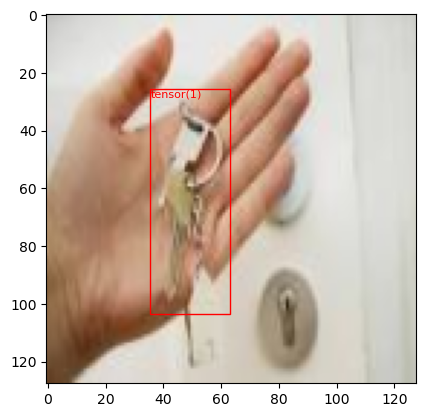

In [7]:
img, target = custom_dataset[14]
plot_image_with_boxes(img, target)

## Function that returns the modified head of the model

In [8]:
def get_object_detection_model(num_classes):
    # Model pre-trained with COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    # freeze all the layers but the head
    for param in model.parameters():
        param.requires_grad = False
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [9]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                        ToTensorV2(p=1.0)], 
                        bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([ToTensorV2(p=1.0)], 
                         bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Preparing the data_loader

In [10]:
dataset = CustomImagesDataset(train_dir, 128, 128, transforms= get_transform(train=True))
dataset_test = CustomImagesDataset(train_dir, 128, 128, transforms= get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# split the dataset in train and test set
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False,
    collate_fn=utils.collate_fn)

In [11]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

## Function to load another model before training

In [12]:
def load_model(file_path, model, optimizer=None, lr_scheduler=None):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    if lr_scheduler is not None and 'lr_scheduler_state_dict' in checkpoint:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    
    epoch = checkpoint['epoch'] if 'epoch' in checkpoint else None
    print(f"Model loaded from {file_path}")
    
    return model, optimizer, lr_scheduler, epoch

In [14]:
model, optimizer, lr_scheduler, num_epochs = load_model('saved_models/model_finetuned_v1.pth', model, optimizer, lr_scheduler)

Model loaded from saved_models/model_finetuned_v1.pth


## Training the model

In [24]:
num_epochs = 4

for epoch in range(num_epochs):
    # evaluation is included in this method
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [ 0/21]  eta: 0:03:42  lr: 0.000025  loss: 0.6863 (0.6863)  loss_classifier: 0.3063 (0.3063)  loss_box_reg: 0.2378 (0.2378)  loss_objectness: 0.1180 (0.1180)  loss_rpn_box_reg: 0.0242 (0.0242)  time: 10.5717  data: 0.0529
Epoch: [0]  [10/21]  eta: 0:02:43  lr: 0.000275  loss: 0.1902 (0.2564)  loss_classifier: 0.0667 (0.0883)  loss_box_reg: 0.1035 (0.1269)  loss_objectness: 0.0059 (0.0232)  loss_rpn_box_reg: 0.0117 (0.0179)  time: 14.8816  data: 0.0267
Epoch: [0]  [20/21]  eta: 0:00:13  lr: 0.000500  loss: 0.1902 (0.2267)  loss_classifier: 0.0670 (0.0810)  loss_box_reg: 0.0974 (0.1121)  loss_objectness: 0.0059 (0.0174)  loss_rpn_box_reg: 0.0117 (0.0161)  time: 14.1114  data: 0.0160
Epoch: [0] Total time: 0:04:52 (13.9431 s / it)
Epoch: [1]  [ 0/21]  eta: 0:04:29  lr: 0.000500  loss: 0.2340 (0.2340)  loss_classifier: 0.0843 (0.0843)  loss_box_reg: 0.1359 (0.1359)  loss_objectness: 0.0042 (0.0042)  loss_rpn_box_reg: 0.0095 (0.0095)  time: 12.8526  data: 0.0170
Epoch: [1]  [10/

## Function to save the trained model

In [21]:
def save_model(model, optimizer, lr_scheduler, epoch, file_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"Model saved in {file_path}")

save_model(model, optimizer, lr_scheduler, num_epochs, 'model_finetuned_v1.pth')

Model saved in model_finetuned_v1.pth


## Function that aplies a threshold to the confidence of the predictions

In [15]:
def apply_nms(orig_prediction, iou_thresh=0.2):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

## Testing the results

In [85]:
# pick one image from the test set and evaluate it
img, target = dataset_test[3]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  7
real #boxes:  1


EXPECTED OUTPUT


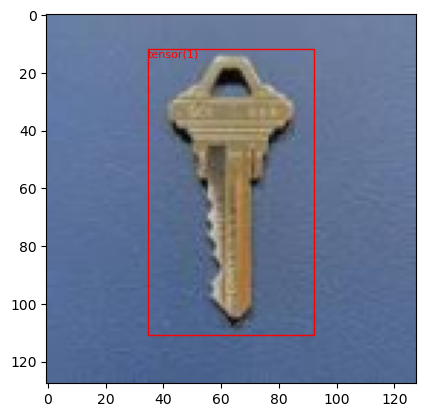

In [86]:
print('EXPECTED OUTPUT')
plot_image_with_boxes(torch_to_pil(img), target)

MODEL OUTPUT


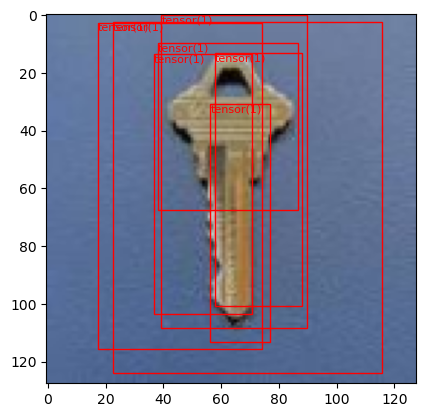

In [87]:
print('MODEL OUTPUT')
plot_image_with_boxes(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


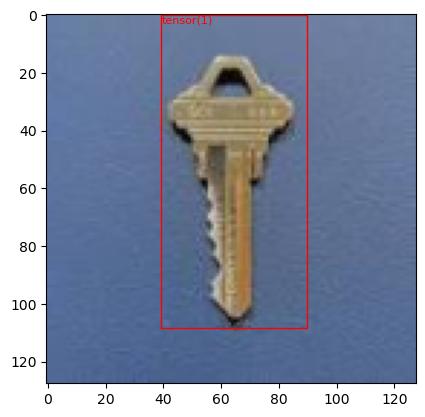

In [88]:
nms_prediction = apply_nms(prediction, iou_thresh=0.05)
print('NMS APPLIED MODEL OUTPUT')
plot_image_with_boxes(torch_to_pil(img), nms_prediction)

EXPECTED OUTPUT



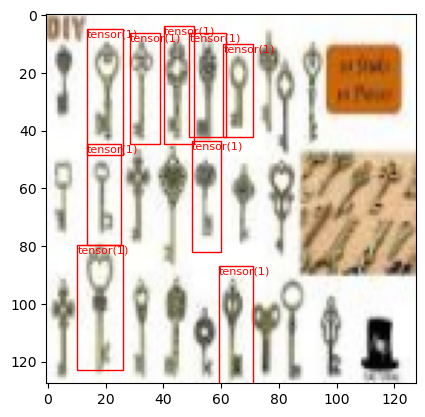

MODEL OUTPUT



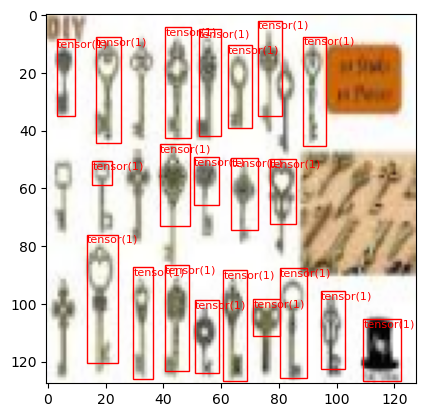

In [89]:
img, target = dataset_test[2]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_image_with_boxes(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_image_with_boxes(torch_to_pil(img), nms_prediction)